# Visual Inspection of Motorcycle Connecting Rods Project

### Lorenzo Balandi - 1005451

Python3 and OpenCV library.

In this file you can find also the links to the webpages used to get informations and tips.

# First Task
To perform the first task we have to binarize the image.
To binarize the image we first look at the graylevel histogram to choose the best strategy.

In [1]:
# Import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

Original images:
Shape =  (255, 256)


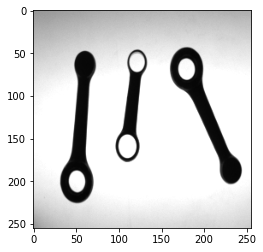

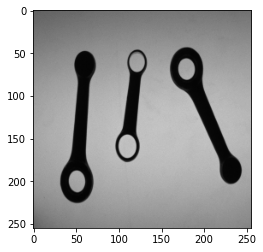

In [29]:
# Import images

print("Original images:")
# Image under analysis
img = cv2.imread("ispezione-bielle-immagini/TESI00.BMP", cv2.IMREAD_GRAYSCALE)
# Image used for visualization
img_rgb = cv2.imread("ispezione-bielle-immagini/TESI00.BMP")
# Second image under analysis
img2 = cv2.imread("ispezione-bielle-immagini/TESI01.BMP", cv2.IMREAD_GRAYSCALE)

print("Shape = ", img.shape)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.show()

I inspect 2 images representing same objects with different lights to understant how to proceed.


From the first task requirements we know that lights can change in intensity.

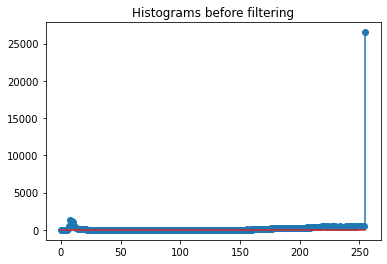

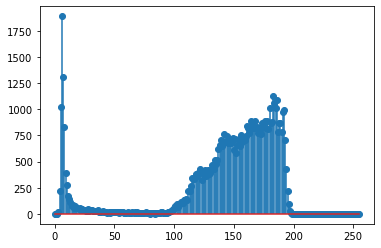

In [30]:
# Histograms
hist,bins = np.histogram(img.flatten(),256,[0,256])
hist2,bins2 = np.histogram(img2.flatten(),256,[0,256])

# Plotting the histograms
plt.title("Histograms before filtering")
plt.stem(hist, use_line_collection=True)
plt.show()
plt.stem(hist2, use_line_collection=True)
plt.show()

As we can see, in the first image the foreground objects are already almost black, conversely the background
colour not uniform.

In the second image the graylevels are differently distributed and both histograms can be tough of as **BIMODAL**.

First to all, a denoising filter could help binarization.

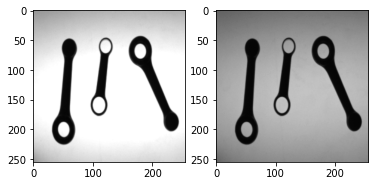

In [4]:
# Apply a gaussian filter to denoise and improve binarization (a bit of noise is always present)
def denoise(img):
    sigma = 0.5
    k_size = int(np.ceil((3*sigma))*2 + 1) #rule of thumb for a good kernel size given sigma (see slides)
    img_filtered = cv2.GaussianBlur(img, (k_size,k_size) , sigma)
    return img_filtered  

img_filtered = denoise(img)
img2_filtered = denoise(img2)    

# Plot the results
plt.subplot(1,2,1)
plt.imshow(img_filtered,cmap='gray',vmin=0,vmax=255)
plt.subplot(1,2,2)
plt.imshow(img2_filtered,cmap='gray',vmin=0,vmax=255)
plt.show()

## Binarization

In [5]:
# Binarization "by hand" (without OpenCV functions)
# (Naive implementation)

def binarize(img, T):
    height = img.shape[0]
    width = img.shape[1]
    for i in range(height):
        for j in range(width):
            if img[i,j] <= T:
                img_bin[i,j] = 0 # black
            else:
                img_bin[i,j] = 255 # white
    return img_bin

The reult is not optimal and is not the same for the two images. Being the histograms bimodal we can use **Otsu's algorithm** (automatic threshold selection) to compute the threshold and we can avoid adaptive thresholding and colour based segmentation.
If the light source is of different power the histograms will be different but **bimodal**, so Otsu is the right choice as it will compute a different threshold for any image and it will fullfil Task 1 requirement.


Using **OpenCV functions**:

https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

In [6]:
img_bin = np.copy(img_filtered)
img2_bin = np.copy(img2_filtered)

T,img_bin = cv2.threshold(img_filtered,60,255,cv2.THRESH_BINARY)
#plt.imshow(img_bin,cmap='gray',vmin=0,vmax=255)
#plt.show()
# static thresholding: same results as before

img_bin = cv2.adaptiveThreshold(img_filtered,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,7,10)
img2_bin = cv2.adaptiveThreshold(img_filtered,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,10)
#plt.imshow(img_bin,cmap='gray',vmin=0,vmax=255)
#plt.show()
# adaptive thresholding (mean and gaussian): not the right choice in this case

Otsu's results: Threshold_1 = 128.0, Threshold_2 = 86.0


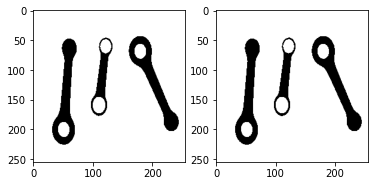

In [7]:
# Otsu's thresholding
T,img_bin = cv2.threshold(img_filtered,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
T2,img2_bin = cv2.threshold(img2_filtered,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

print("Otsu's results: Threshold_1 = {}, Threshold_2 = {}" .format(T,T2))
plt.subplot(1,2,1)
plt.imshow(img_bin,cmap='gray',vmin=0,vmax=255)
plt.subplot(1,2,2)
plt.imshow(img2_bin,cmap='gray',vmin=0,vmax=255)
plt.show()

# Used for report
#cv2.imwrite("otsu1.bmp", img_bin)
#cv2.imwrite("otsu2.bmp", img2_bin)

## Connected Components Labeling

Since the binarized images are almost equal, from now on we can consider only the first.


Now we have to perform the **Connected Components Labeling**.

https://iq.opengenus.org/connected-component-labeling/

In [8]:
# Invert the image (if you don't do this the CCL algorithm will mark the component as background!)
img_bin = 255-img_bin

img_labeled = np.copy(img_bin)

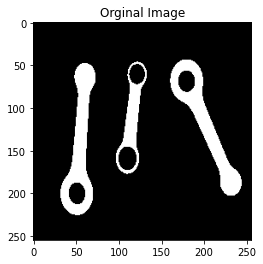

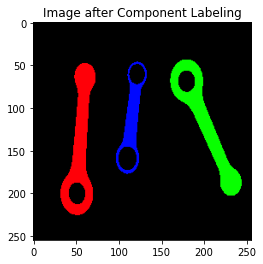

In the image there are 3 connected components.


In [9]:
# Connected Components Labeling function:
def CCL (img_bin):
    
    num_labels, labels = cv2.connectedComponents(img_bin)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(img_bin,cmap='gray',vmin=0,vmax=255)
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    plt.title("Image after Component Labeling")
    plt.show()
    #cv2.imwrite("labeled_img.bmp", labeled_img)
    
# For visualization:
img_labeled = CCL(img_bin)
# For use:
num_labels, img_labeled = cv2.connectedComponents(img_bin)
print("In the image there are", (num_labels-1),  "connected components.") # -1 because also the background is considered

# Used for report
#cv2.imwrite("img_bin.bmp", img_bin)


To work with connected component after having found them:
https://stackoverflow.com/questions/51523765/how-to-use-opencv-connectedcomponents-to-get-the-images

We have to found if the connecting rod under analysis is of type A (1 hole) or B (2 holes).
Unfortunately, a function to compute the Eueler number doesn't seem to exist :(

https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html

https://docs.opencv.org/master/d9/d8b/tutorial_py_contours_hierarchy.html

The above links suggest that the function findContours returns also a hierarchy array: we can exploit it to find the number of holes of the connecting rods. In fact, if the component has 3 holes (Type B) 3 contours are found and thus the hierarchy matrix has shape 3x4, if the component has 2 holes (Type A) 2 contours are found and the hierarchy matrix is 2x4.

Type A


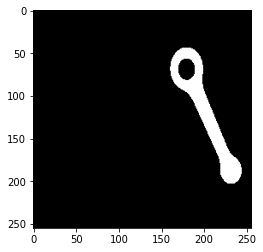

Type B


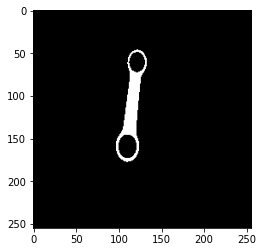

Type A


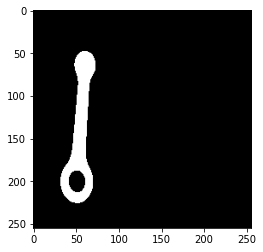

In [10]:
# num_labels, img_labeled = cv2.connectedComponents(img_bin)

# getting mask with connectComponents
for label in range(1,num_labels):
    mask = np.array(img_labeled, dtype=np.uint8)
    mask[img_labeled == label] = 255
    mask[img_labeled != label] = 0  # NECESSARIA QUESTA RIGA? apparentemente si
    
    # copy the mask image vor visualization purposes
    mask_rect = np.copy(mask) 
    # change to RGB to visualize shapes in red
    mask_rect_rgb = cv2.cvtColor(mask_rect,cv2.COLOR_GRAY2RGB)
    
    # Contours extraction
    contour,hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # in the hierarchy matrix the number of rows (contours) is actually in the second position (index = 1)
    if hierarchy.shape[1] == 3:
        Type = 'B'
    elif hierarchy.shape[1] == 2:
        Type = 'A'
    else:
        print("The piece is not Tipe A nor Type B")
    print("Type",Type)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
    plt.show()
    


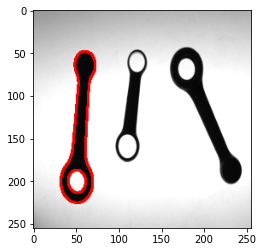

In [11]:
# SEE THIS FOR SECOND TASK 2 
# https://answers.opencv.org/question/87583/detach-blobs-with-a-contact-point/
# https://theailearner.com/2020/11/09/convexity-defects-opencv/
'''
prv = np.copy(mask)

cnt = contour[-1]
hull = cv2.convexHull(cnt, returnPoints = False)
defects = cv2.convexityDefects(cnt, hull)

for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    cv2.line(prv,start,end,[100,100,0],2)
    cv2.circle(prv,far,5,[100,0,100],-1)
plt.imshow(prv)
plt.show()

'''

prv = np.copy(img_rgb)
cv2.drawContours(prv, contour, -1, (0,0,255), 2)
plt.imshow(cv2.cvtColor(prv,cv2.COLOR_BGR2RGB))
plt.show()


## Barycenter, orientation, Length, Width

Now we have to perform some analysis on the extracted blobs. Let's start with the position (of the barycentre).

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html

https://learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/

https://docs.opencv.org/3.4/d8/d23/classcv_1_1Moments.html

To compute the **barycenter** position we can use the formula x = M10/M00, y = M01/M00 (where M00 is the Area) . To know the **moments** we can use the apposite function of opencv, that returns spatial moments, central moments and central normalized moments, but here we need only the spatial ones because we don't have to compare different pieces so we don't need rotation and scale invariancy.

In [12]:
def get_barycenter_and_area(img):
    moments = cv2.moments(img) # returns a dictionary ('moment':value)
    # from the last link above we know that also the pixel intensity is multiplied to compute the moments,
    # but we don't care because this multiplication is performed for all the images under analysis and 
    # always the same number considered (255)
    # coordinates of barycenter
    Bx = int(moments["m10"] / moments["m00"])
    By = int(moments["m01"] / moments["m00"])
    area = moments["m00"]
    return Bx,By,area,moments

Bx,By,area,moments = get_barycenter_and_area(mask)
print("Coordinates of barycenter: x = {}, y = {}. Area = {}" .format(Bx,By,area))

Coordinates of barycenter: x = 54, y = 141. Area = 832065.0


Now, always using 'mask', compute **orientation**. We can apply the formula on course slides, since we have all the moments. **N.B.** we have to use central moments. Another possibility is to use the fitEllipse function.

In [13]:
# The orientation is determined modulo Pi (from -90 to 90)
def get_orientation(moments):
    #teta_rad = -0.5*np.arctan((2*moments["mu11"])/(moments["mu02"]-moments["mu20"]))
    #teta = (np.degrees(teta_rad)) # abs to get the modulo pi angle
    (x,y),(MA,ma),teta = cv2.fitEllipse(contour[-1])
    # fitEllipse function returns angle wrt the vertical axis
    return (90 - teta)


teta = get_orientation(moments)
print("Orientation: teta = {:.1f}" .format(teta))

Orientation: teta = 86.1


To find **Length** and **Width** we can use the Minimum Enclosing Rectangle (**MER**).

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html

https://docs.opencv.org/3.4/d1/d32/tutorial_py_contour_properties.html

https://www.programcreek.com/python/example/89409/cv2.fitEllipse

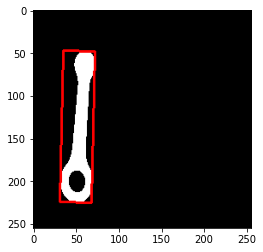

The piece has size: H = 177, W = 37


In [14]:
def get_length_and_width(contour):
    MER = cv2.minAreaRect(contour[-1]) # -1 to get the outer contour and not the hole one
    MER_center = MER[0]
    MER_size = MER[1] # this is used, you can comment the others
    MER_angle = MER[2]
    box = cv2.boxPoints(MER)
    box = np.int0(box) # coordinates of the enclosing rectangle
    im = cv2.drawContours(mask_rect_rgb,[box],0,(255,0,0),2)
    plt.imshow(mask_rect_rgb)
    plt.show()
    return MER_size

MER_size = get_length_and_width(contour)
H = int(MER_size[0])
W = int(MER_size[1])
#print(MER_center,MER_size,MER_angle)
print("The piece has size: H = {}, W = {}" .format(H,W))

## Width at the barycenter (Wb)

**Width at the barycenter**: we know the slope of the line and a point (barycenter). We need to compute the length of the line passing through barycenter and with known slope. Using the relations: x2 = x1 + length * cos(θ)
    y2 = y1 + length * sin(θ) we can obtain 2 points and draw a line using cv2.line(). Then, moving through this line we can initialize Wb as 0 and increment it if we encounter a point with intensity = 255 (foreground pixel). At the end we have **half** the width at the barycenter, so we can multiply by 2 or do the same computation in the opposite direction.

Note that the actually computation has some changed signs due to the downward y axis (this caused me a lot of troubles before finding the problem!).
    
https://stackoverflow.com/questions/22252438/draw-a-line-using-an-angle-and-a-point-in-opencv

[ 54 141] [ 91 143]
[ 54 141] [ 16 138]


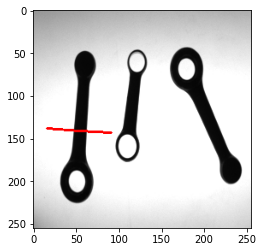

86.10017156600952 -3.899828433990479


-0.06801230320736894

In [15]:
# This section is used to draw the line through which Wb is computed (for graphical debugging)

# Line from barycenter, directed as teta, length = width
mask_rect_rgb2 = np.copy(img_rgb)

if (teta > 0):
    angle = np.radians(teta - 90)
else:
    angle = np.radians(teta + 90)

length = np.minimum(MER_size[0],MER_size[1]) # follow the direction of the width
P = np.array([Bx,By])  
P2 = np.zeros((2,),dtype=np.int) # initialize P2 as zeros
P2[0] = (P[0] + length * np.cos(angle))
P2[1] = (P[1] - length * np.sin(angle)) # - because the axis is directed downward 
print(P,P2)
line1 = cv2.line(mask_rect_rgb2,(Bx,By),(P2[0],P2[1]),(255,0,0),2)


# Line from barycenter, directed as teta, length = width, OPPOSITE direction than previous line
P2[0] = (P[0] - length * np.cos(angle)) 
P2[1] = (P[1] + length * np.sin(angle))
print(P,P2)
line2 = cv2.line(mask_rect_rgb2,(Bx,By),(P2[0],P2[1]),(255,0,0),2)
plt.imshow(mask_rect_rgb2)
plt.show()

print(teta,np.degrees(angle))
np.sin(angle)

In [16]:
# outer_contour

In [17]:
# This function goes through the line and increment Wb if the pixel under analysis belongs to foreground
def get_Wb(Bx,By,teta):
    P = np.array([[Bx,By]],dtype=np.int32) 
    P2 = np.zeros((1,2),dtype=np.int32) # initialize P2 as zeros
    # teta spaces from -90 to +90
    if (teta > 0):
        angle = np.radians(teta - 90)
    else:
        angle = np.radians(teta + 90)
    i = 0
    Wb = 0
    for i in range(int(length)):
        P2[0,0] = int(P[0,0] + i * np.cos(angle))
        P2[0,1] = int(P[0,1] - i * np.sin(angle)) # - because the axis is directed downward 
        #print(P2)
        #print()
        if (mask[P2[0,1],P2[0,0]] == 255):
            Wb+=1
        i+=1
    return Wb

Wb = get_Wb(Bx,By,teta)
Wb *= 2
print("The width at the barycenter is: Wb =", Wb)

The width at the barycenter is: Wb = 20


## Position of holes, diameter size

Now we have to find the **position of the centre** and the **diameter size** of each **hole**. 

There are several ways to do that:
* **Hough Transform** for circle detection: it won't work in this case because the holes in the connecting rods images are ellpises
* Use the **minimum enclosing circle** and its coordinates and radius for the hole(s) contour(s)
* Use the **generalized Hough Transform**

The second method is the simplest one (but the less accurate).

In [18]:
# This was the unsuccessful try to use the Hough Transform
'''
# detect circles in the image
holes = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, 10,minRadius=0, maxRadius=0)
# 30 is the minimum distance between center coordinates, 1.2 is a parameter related to the acculumator resolution
# ensure at least some circles were found

if holes is not None:
    print("Found hole(s)")
    # convert the (x, y) coordinates and radius of the circles to integers
    holes = np.round(holes[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in holes:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(mask_rect, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(mask_rect, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
else: print("Hole(s) not found")

# show the output image
plt.imshow(mask_rect)
plt.show()

'''

'\n# detect circles in the image\nholes = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, 10,minRadius=0, maxRadius=0)\n# 30 is the minimum distance between center coordinates, 1.2 is a parameter related to the acculumator resolution\n# ensure at least some circles were found\n\nif holes is not None:\n    print("Found hole(s)")\n    # convert the (x, y) coordinates and radius of the circles to integers\n    holes = np.round(holes[0, :]).astype("int")\n    # loop over the (x, y) coordinates and radius of the circles\n    for (x, y, r) in holes:\n        # draw the circle in the output image, then draw a rectangle\n        # corresponding to the center of the circle\n        cv2.circle(mask_rect, (x, y), r, (0, 255, 0), 4)\n        cv2.rectangle(mask_rect, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)\nelse: print("Hole(s) not found")\n\n# show the output image\nplt.imshow(mask_rect)\nplt.show()\n\n'

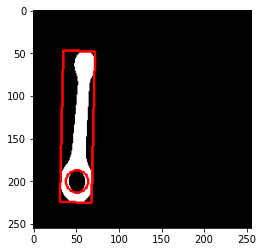

The hole position is: x = 51, y = 200, the diameter is: D = 26


In [19]:
# Find center coordinates and radius using the Minimum Enclosing Circle applied on the inner contour
# N.B. IF THERE ARE 2 HOLES (TYPE B) WE HAVE TO FIND 2 CIRCLES!

def get_holes(contour,Type):
    (x,y),radius = cv2.minEnclosingCircle(contour[0])
    # cast to int to draw the circle
    x = int(x); y= int(y); radius = int(radius)
    cv2.circle(mask_rect_rgb, (x,y), radius, (255, 0, 0), 2)
    if (Type == 'B'):
        (x2,y2),radius2 = cv2.minEnclosingCircle(contour[1])
        # cast to int to draw the circle
        x2 = int(x2); y2= int(y2); radius2 = int(radius2)
        cv2.circle(mask_rect_rgb, (x2,y2), radius2, (255, 0, 0), 2)
        plt.imshow(mask_rect_rgb)
        plt.show()
        return x,y,radius,x2,y2,radius2
    # visualize the drawn circles   
    plt.imshow(mask_rect_rgb)
    plt.show()
    return x,y,radius

if (Type == 'A'):
    x,y,radius = get_holes(contour,Type)
    print("The hole position is: x = {}, y = {}, the diameter is: D = {}" .format(x,y,2*radius)) 
else:
    x,y,radius,x2,y2,radius2 = get_holes(contour,Type)
    print("The holes positions are: x = {}, y = {} with diameter: D = {}; x2 = {}, y2 = {} with diameter2: D2 = {}" .format(x,y,2*radius,x2,y2,2*radius2)) 

    

## Generalization of the procedure
Generalization of the procedure to **all images of Task 1**.

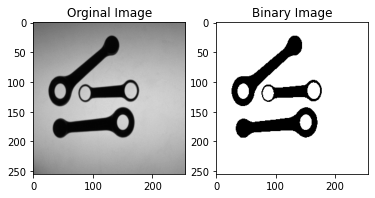

Otsu's results: Threshold = 94.0


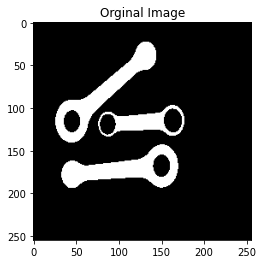

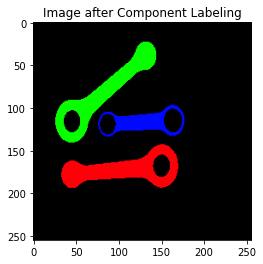

In the image there are 3 connected components.
Type A


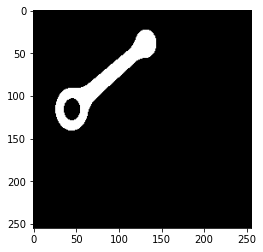

Coordinates of barycenter: x = 82, y = 82. Area = 835125.0
Orientation: teta = 41.8


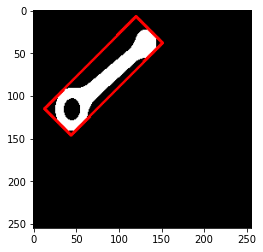

The piece has size: H = 152, W = 43
The width at the barycenter is: Wb = 20


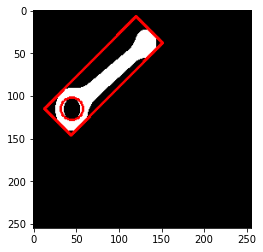

The hole position is: x = 45, y = 115, the diameter is: D = 26
Type B


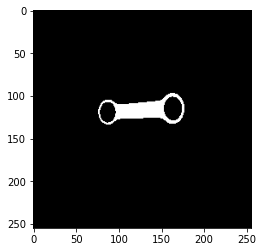

Coordinates of barycenter: x = 128, y = 116. Area = 376380.0
Orientation: teta = 3.6


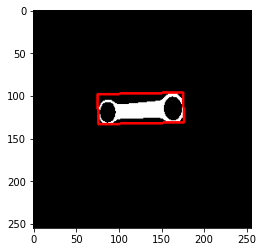

The piece has size: H = 100, W = 35
The width at the barycenter is: Wb = 24


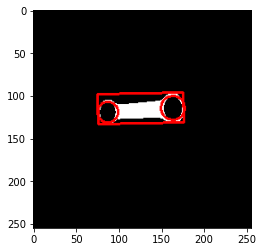

The holes positions are: x = 87, y = 119 with diameter: D = 24; x2 = 163, y2 = 114 with diameter2: D2 = 28
Type A


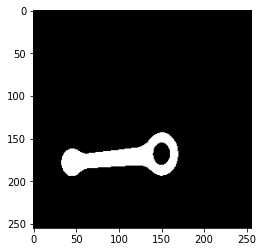

Coordinates of barycenter: x = 104, y = 172. Area = 830790.0
Orientation: teta = 5.3


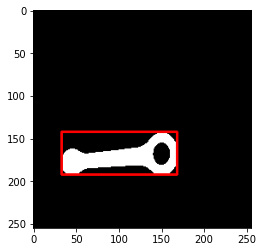

The piece has size: H = 135, W = 49
The width at the barycenter is: Wb = 24


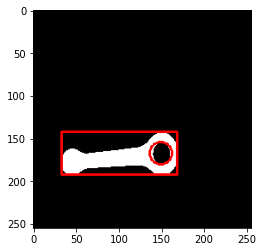

The hole position is: x = 149, y = 167, the diameter is: D = 26


In [20]:
first_task_images = ["TESI00.BMP","TESI01.BMP","TESI12.BMP","TESI21.BMP","TESI31.BMP","Tesi33.bmp"]

img = cv2.imread("ispezione-bielle-immagini/TESI12.BMP", cv2.IMREAD_GRAYSCALE)
plt.title("Orginal Image")
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title("Orginal Image")

# Denoise the image
img_filtered = denoise(img)   

# Otsu's Binarization
T,img_bin = cv2.threshold(img_filtered,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(1,2,2)
plt.imshow(img_bin,cmap='gray',vmin=0,vmax=255)
plt.title("Binary Image")
plt.show()
print("Otsu's results: Threshold = {}" .format(T))

# Invert the image (if you don't do this the CCL algorithm will mark the component as background!)
img_bin = 255-img_bin
img_labeled = np.copy(img_bin)

# Connected Components Detection
# For visualization:
img_labeled = CCL(img_bin)
# For use:
num_labels, img_labeled = cv2.connectedComponents(img_bin)
print("In the image there are", (num_labels-1),  "connected components.") # -1 because also the background is considered

# getting mask with connectComponents
for label in range(1,num_labels):
    mask = np.array(img_labeled, dtype=np.uint8)
    mask[img_labeled == label] = 255
    mask[img_labeled != label] = 0
    
    # copy the mask image vor visualization purposes
    mask_rect = np.copy(mask) 
    # change to RGB to visualize shapes in red
    mask_rect_rgb = cv2.cvtColor(mask_rect,cv2.COLOR_GRAY2RGB)
    
    # Contours extraction
    contour,hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # in the hierarchy matrix the number of rows (contours) is actually in the second position (index = 1)
    if hierarchy.shape[1] == 3:
        Type = 'B'
    elif hierarchy.shape[1] == 2:
        Type = 'A'
    else:
        print("The piece is not Tipe A nor Type B")
    print("Type",Type)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    # Barycenter and Area
    Bx,By,area,moments = get_barycenter_and_area(mask)
    print("Coordinates of barycenter: x = {}, y = {}. Area = {}" .format(Bx,By,area))
    
    # Orientation
    teta = get_orientation(moments)
    print("Orientation: teta = {:.1f}" .format(teta))
    
    # Length and Width
    mask_rect = np.copy(mask) # new image used for visualization
    MER_size = get_length_and_width(contour)
    H = int(MER_size[0])
    W = int(MER_size[1])
    print("The piece has size: H = {}, W = {}" .format(H,W))
    
    # Width at barycenter
    Wb = get_Wb(Bx,By,teta)
    Wb *= 2
    print("The width at the barycenter is: Wb =", Wb)
    
    # Position and diameter of holes
    if (Type == 'A'):
        x,y,radius = get_holes(contour,Type)
        print("The hole position is: x = {}, y = {}, the diameter is: D = {}" .format(x,y,2*radius)) 
    else:
        x,y,radius,x2,y2,radius2 = get_holes(contour,Type)
        print("The holes positions are: x = {}, y = {} with diameter: D = {}; x2 = {}, y2 = {} with diameter2: D2 = {}" .format(x,y,2*radius,x2,y2,2*radius2)) 
    
    
    

# Second Task
I decided to modify the code to deal with changes 1 and 3

### First change
To deal with other objects, we have to characterize the rods, e.g. in terms of Area, circularity, length, width...

The same initial analysis is performed (denoising, binarization, connented components labeling), then each blob is analyzed and if it has not the right characteristics it is discarded.
By looking at the previous analysis we can claim that the area of the smallest rods is about 370000, and processing the images of the second task we see that the biggest piece that have to be discarded has area about 270000. So we can filter out all blobs with area < threshold that can be chosen = 300000.

For this reason, as soon as the blob is recognized, the area is computed and an if statement is used to discard the distractors.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

### Third change
To eliminate the iron powder we can treat it as salt-and-pepper noise and use a **median filter**. I define a new function to apply median and gaussian filters. However, since the powder grains can be big, this is not sufficient. 

Hence I perform an **opening operation**. The remaining powder grains will be exluded due to the area analysis highlighted in the first change.

In [21]:
# Apply median filter and gaussian filter (see Task 2, third change)
def double_denoise (img):
    img_filtered = cv2.medianBlur(img, 3)
    sigma = 0.5
    k_size = int(np.ceil((3*sigma))*2 + 1) #rule of thumb for a good kernel size given sigma (see slides)
    img_filtered = cv2.GaussianBlur(img, (k_size,k_size) , sigma)
    return img_filtered  

def opening(img):
    kernel = np.ones((2,2),np.uint8)
    img_bin = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img_bin


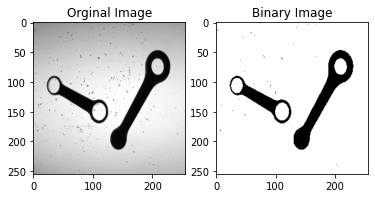

Otsu's results: Threshold = 115.0


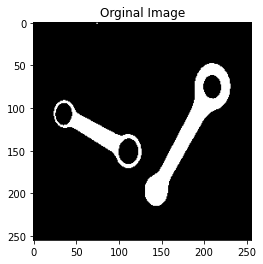

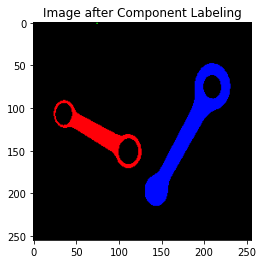

In the image there are 3 connected components.
Type A


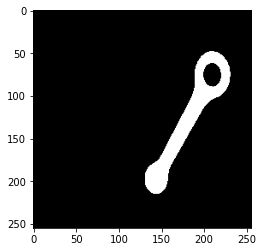

Coordinates of barycenter: x = 180, y = 127. Area = 989400.0
Orientation: teta = 62.4


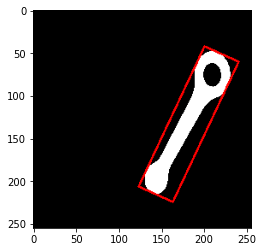

The piece has size: H = 181, W = 44
The width at the barycenter is: Wb = 22


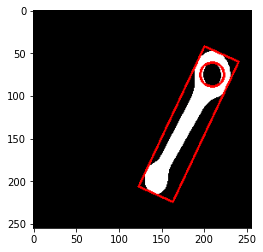

The hole position is: x = 209, y = 75, the diameter is: D = 28
Type B


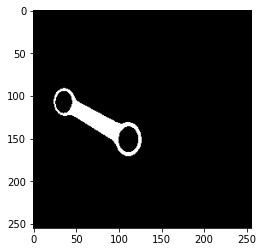

Coordinates of barycenter: x = 77, y = 130. Area = 458235.0
Orientation: teta = -30.4


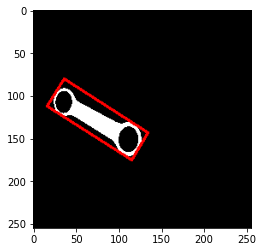

The piece has size: H = 37, W = 116
The width at the barycenter is: Wb = 18


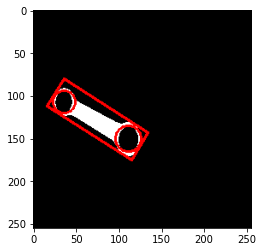

The holes positions are: x = 111, y = 150 with diameter: D = 30; x2 = 36, y2 = 107 with diameter2: D2 = 26


In [31]:
first_task_images = ["TESI00.BMP","TESI01.BMP","TESI12.BMP","TESI21.BMP","TESI31.BMP","Tesi33.bmp"]
second_task_images = ["TESI44.BMP","TESI47.BMP","TESI48.BMP","TESI49.BMP","TESI90.BMP","TESI92.BMP","TESI98.BMP"]

img = cv2.imread("ispezione-bielle-immagini/TESI98.BMP", cv2.IMREAD_GRAYSCALE)
plt.title("Orginal Image")
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title("Orginal Image")

# Denoise the image applying median and gaussian blur
img_filtered = double_denoise(img)   

# Otsu's Binarization
T,img_bin = cv2.threshold(img_filtered,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(1,2,2)
plt.imshow(img_bin,cmap='gray',vmin=0,vmax=255)
plt.title("Binary Image")
plt.show()
print("Otsu's results: Threshold = {}" .format(T))

# Invert the image (if you don't do this the CCL algorithm will mark the component as background!)
img_bin = 255-img_bin

# Opening operation to get rid of iron powder
img_bin = opening(img_bin)

img_labeled = np.copy(img_bin)

# Connected Components Detection
# For visualization:
img_labeled = CCL(img_bin)
# For use:
num_labels, img_labeled = cv2.connectedComponents(img_bin)
print("In the image there are", (num_labels-1),  "connected components.") # -1 because also the background is considered

# getting mask with connectComponents
for label in range(1,num_labels):
    mask = np.array(img_labeled, dtype=np.uint8)
    mask[img_labeled == label] = 255
    mask[img_labeled != label] = 0
    
    # copy the mask image vor visualization purposes
    mask_rect = np.copy(mask) 
    # change to RGB to visualize shapes in red
    mask_rect_rgb = cv2.cvtColor(mask_rect,cv2.COLOR_GRAY2RGB)
    
    # Barycenter and Area
    Bx,By,area,moments = get_barycenter_and_area(mask)
    
    # discard all blobs with area < threshold
    if (area > 300000):
        # Contours extraction
        contour,hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        # in the hierarchy matrix the number of rows (contours) is actually in the second position (index = 1)
        if hierarchy.shape[1] == 3:
            Type = 'B'
        elif hierarchy.shape[1] == 2:
            Type = 'A'
        else:
            print("The piece is not Tipe A nor Type B")
        print("Type",Type)
        plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
        plt.show()

        print("Coordinates of barycenter: x = {}, y = {}. Area = {}" .format(Bx,By,area))

        # Orientation
        teta = get_orientation(moments)
        print("Orientation: teta = {:.1f}" .format(teta))

        # Length and Width
        mask_rect = np.copy(mask) # new image used for visualization
        MER_size = get_length_and_width(contour)
        H = int(MER_size[0])
        W = int(MER_size[1])
        print("The piece has size: H = {}, W = {}" .format(H,W))

        # Width at barycenter
        Wb = get_Wb(Bx,By,teta)
        Wb *= 2
        print("The width at the barycenter is: Wb =", Wb)
        
        # Position and diameter of holes
        if (Type == 'A'):
            x,y,radius = get_holes(contour,Type)
            print("The hole position is: x = {}, y = {}, the diameter is: D = {}" .format(x,y,2*radius)) 
        else:
            x,y,radius,x2,y2,radius2 = get_holes(contour,Type)
            print("The holes positions are: x = {}, y = {} with diameter: D = {}; x2 = {}, y2 = {} with diameter2: D2 = {}" .format(x,y,2*radius,x2,y2,2*radius2)) 
    
    
    